# Exp 107 analysis

See `./informercial/Makefile` for experimental
details.

In [1]:
import os
import numpy as np

from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('ticks')

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('axes', titlesize=16)

from infomercial.exp import wsls_bandit
from infomercial.exp import epsilon_bandit
from infomercial.exp import beta_bandit
from infomercial.exp import softbeta_bandit
from infomercial.local_gym import bandit
from infomercial.exp.wsls_bandit import load_checkpoint

import gym

In [2]:
def plot_meta(env_name, result):
    """Plots!"""
    
    # episodes, actions, scores_E, scores_R, values_E, values_R, ties, policies
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_E = result["scores_E"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]
    values_E = result["values_E"]
    ties = result["ties"]
    policies = result["policies"]
    
    # -
    env = gym.make(env_name)
    best = env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best, np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # Policy
    policies = np.asarray(policies)
    episodes = np.asarray(episodes)
    plt.subplot(grid[1, 0])
    m = policies == 0
    plt.scatter(episodes[m], policies[m], alpha=.4, s=2, label="$\pi_E$", color="purple")
    m = policies == 1
    plt.scatter(episodes[m], policies[m], alpha=.4, s=2, label="$\pi_R$", color="grey")
    plt.ylim(-.1, 1+.1)
    plt.ylabel("Controlling\npolicy")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()
    
    # score
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, scores_E, color="purple", alpha=0.4, s=2, label="E")
    plt.plot(episodes, scores_E, color="purple", alpha=0.4)
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.plot(episodes, scores_R, color="grey", alpha=0.4)
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Score")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, values_E, color="purple", alpha=0.4, s=2, label="$Q_E$")
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Value")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    
    # Ties
    plt.subplot(grid[4, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

    # Ties
    plt.subplot(grid[5, 0])
    plt.scatter(episodes, ties, color="black", alpha=.5, s=2, label="$\pi_{tie}$ : 1\n $\pi_\pi$ : 0")
    plt.ylim(-.1, 1+.1)
    plt.ylabel("Ties index")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    
def plot_epsilon(env_name, result):
    """Plots!"""
    
    # episodes, actions, scores_E, scores_R, values_E, values_R, ties, policies
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]
    epsilons = result["epsilons"]
    
    # -
    env = gym.make(env_name)
    best = env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best, np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # score
    plt.subplot(grid[1, 0])
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.ylabel("Score")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.ylabel("Value")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # best
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

    # Decay
    plt.subplot(grid[4, 0])
    plt.scatter(episodes, epsilons, color="black", alpha=.5, s=2)
    plt.ylabel("$\epsilon_R$")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_beta(env_name, result):
    """Plots!"""
    
    # episodes, actions, scores_E, scores_R, values_E, values_R, ties, policies
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]
    beta = result["beta"]
    
    # -
    env = gym.make(env_name)
    best = env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best, np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # score
    plt.subplot(grid[1, 0])
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.ylabel("Score")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.ylabel("Value")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # best
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)
    
    
def plot_critic(critic_name, env_name, result):
    # -
    env = gym.make(env_name)
    best = env.best
    
    # Data
    critic = result[critic_name]
    arms = list(critic.keys())
    values = list(critic.values())

    # Plotz
    fig = plt.figure(figsize=(8, 3))
    grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0])
    plt.scatter(arms, values, color="black", alpha=.5, s=30)
    plt.plot([best]*10, np.linspace(min(values), max(values), 10), color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Value")
    plt.xlabel("Arm")

# Load and process data

In [3]:
data_path ="/Users/qualia/Code/infomercial/data/"
exp_name = "exp107"
sorted_params = load_checkpoint(os.path.join(data_path, f"{exp_name}_sorted.pkl"))

In [4]:
# print(sorted_params.keys())
best_params = sorted_params[0]
beta = best_params['beta']
sorted_params

{0: {'beta': 0.289126807462302,
  'lr_R': 0.17824610735501137,
  'total_R': 33195.0},
 1: {'beta': 1.7012286049601217,
  'lr_R': 0.1542630930523359,
  'total_R': 33158.0},
 2: {'beta': 0.2530701722730706,
  'lr_R': 0.14092832340588582,
  'total_R': 32665.0},
 3: {'beta': 0.0707754062202308,
  'lr_R': 0.06628579376259411,
  'total_R': 32628.0},
 4: {'beta': 0.7971481885174169,
  'lr_R': 0.05226515242072033,
  'total_R': 32623.0},
 5: {'beta': 1.327197432940004,
  'lr_R': 0.06190924182451216,
  'total_R': 32587.0},
 6: {'beta': 1.5353418395710277,
  'lr_R': 0.19035133840924787,
  'total_R': 32551.0},
 7: {'beta': 1.3586685461123729,
  'lr_R': 0.09307657749809956,
  'total_R': 32521.0},
 8: {'beta': 1.9990382088091752,
  'lr_R': 0.1816288836682704,
  'total_R': 32462.0},
 9: {'beta': 0.2115876598409998,
  'lr_R': 0.19707052179970344,
  'total_R': 32448.0},
 10: {'beta': 0.4755224581105376,
  'lr_R': 0.14827282884494433,
  'total_R': 32392.0},
 11: {'beta': 1.6247732967126054,
  'lr_R': 0.

# Performance

of best parameters

{'beta': 0.289126807462302, 'lr_R': 0.17824610735501137, 'total_R': 33195.0}
Best arm: [54], last arm: 77


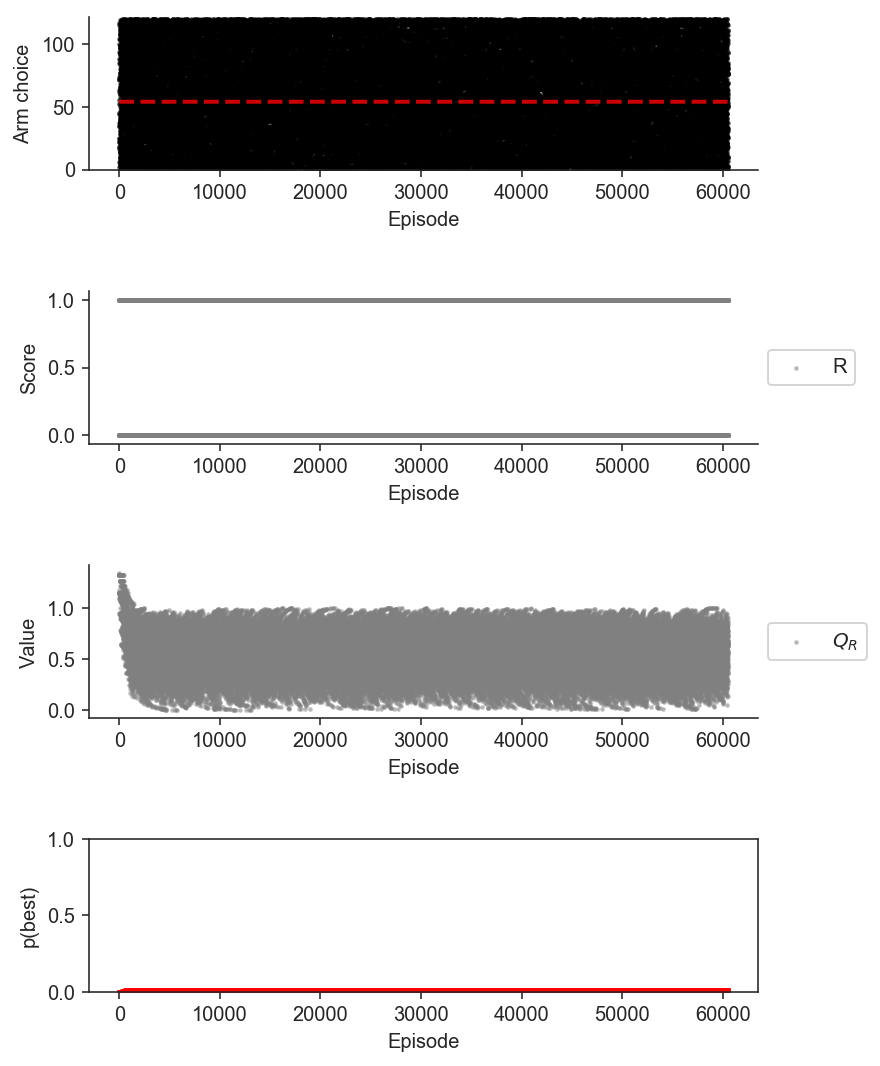

In [5]:
env_name = 'BanditUniform121-v0'
num_episodes = 60500

# Run w/ best params
result = softbeta_bandit(
    env_name=env_name,
    num_episodes=num_episodes, 
    lr_R=best_params["lr_R"],
    beta=best_params["beta"],
    seed_value=2,
)

print(best_params)
plot_beta(env_name, result=result)

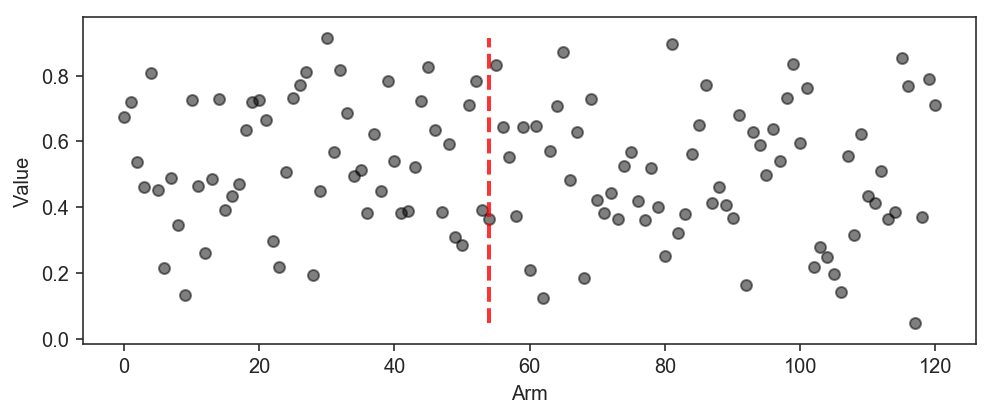

In [13]:
plot_critic('critic', env_name, result)

# Sensitivity

to parameter choices

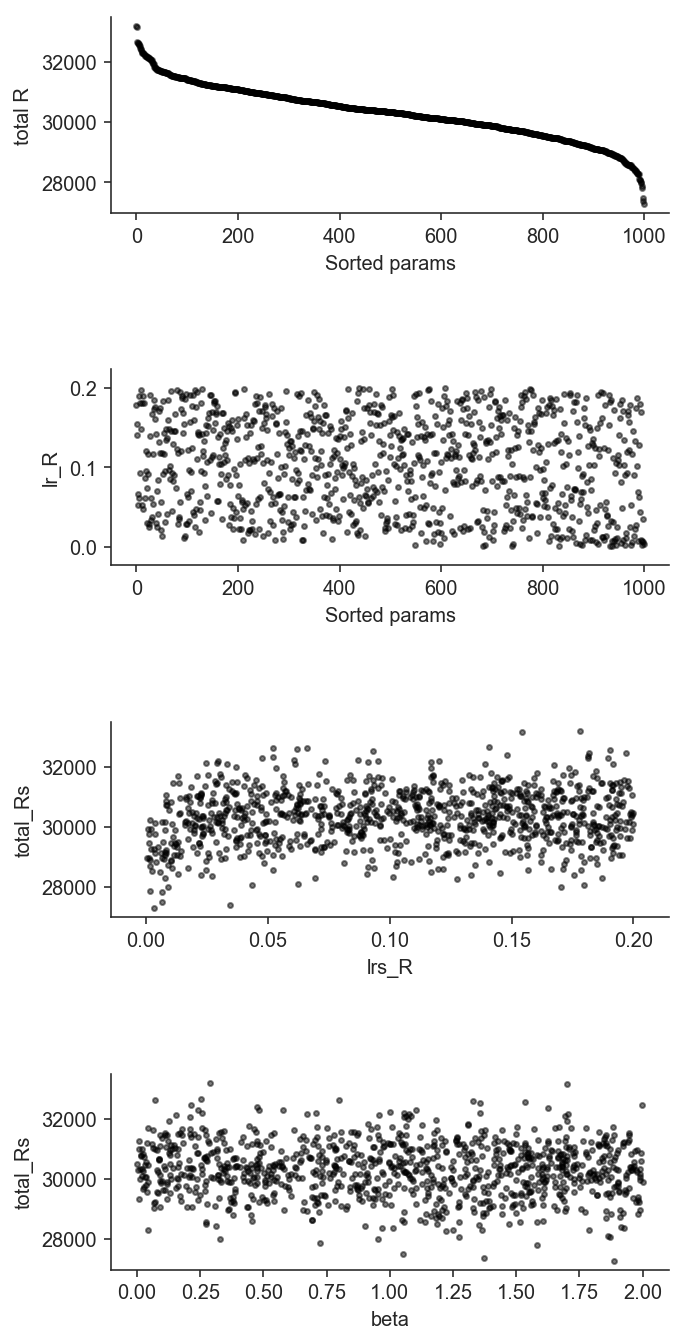

In [14]:
total_Rs = [] 
betas = []
lrs_R = []
lrs_E = []
trials = list(sorted_params.keys())
for t in trials:
    total_Rs.append(sorted_params[t]['total_R'])
    lrs_R.append(sorted_params[t]['lr_R'])
    betas.append(sorted_params[t]['beta'])
    
# Init plot
fig = plt.figure(figsize=(5, 18))
grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

# Do plots:
# Arm
plt.subplot(grid[0, 0])
plt.scatter(trials, total_Rs, color="black", alpha=.5, s=6, label="total R")
plt.xlabel("Sorted params")
plt.ylabel("total R")
_ = sns.despine()


plt.subplot(grid[1, 0])
plt.scatter(trials, lrs_R, color="black", alpha=.5, s=6, label="total R")
plt.xlabel("Sorted params")
plt.ylabel("lr_R")
_ = sns.despine()

plt.subplot(grid[2, 0])
plt.scatter(lrs_R, total_Rs, color="black", alpha=.5, s=6, label="total R")
plt.xlabel("lrs_R")
plt.ylabel("total_Rs")
_ = sns.despine()

plt.subplot(grid[3, 0])
plt.scatter(betas, total_Rs, color="black", alpha=.5, s=6, label="total R")
plt.xlabel("beta")
plt.ylabel("total_Rs")
_ = sns.despine()

# Parameter correlations

In [8]:
from scipy.stats import spearmanr
spearmanr(total_Rs, lrs_R)

SpearmanrResult(correlation=0.11289113065787094, pvalue=0.00034768510563091496)

In [9]:
spearmanr(betas, total_Rs)

SpearmanrResult(correlation=-0.05854801073069254, pvalue=0.06420944963222742)

In [10]:
spearmanr(betas, lrs_R)

SpearmanrResult(correlation=-0.013003033003033005, pvalue=0.6812961319489348)

# Distributions

of parameters

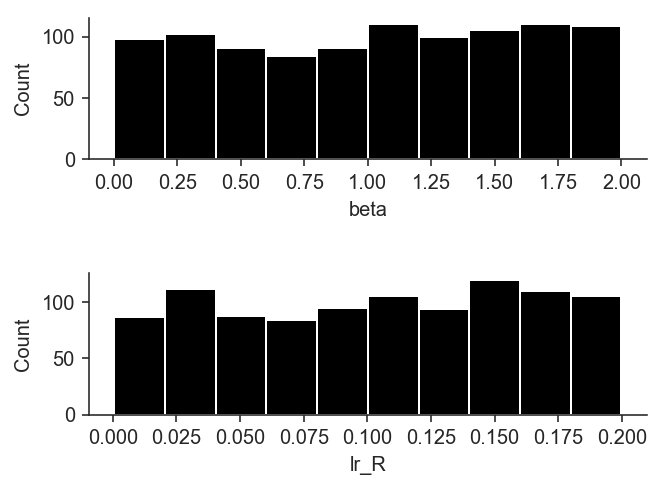

In [11]:
# Init plot
fig = plt.figure(figsize=(5, 6))
grid = plt.GridSpec(3, 1, wspace=0.3, hspace=0.8)

plt.subplot(grid[0, 0])
plt.hist(betas, color="black")
plt.xlabel("beta")
plt.ylabel("Count")
_ = sns.despine()

plt.subplot(grid[1, 0])
plt.hist(lrs_R, color="black")
plt.xlabel("lr_R")
plt.ylabel("Count")
_ = sns.despine()

of total reward

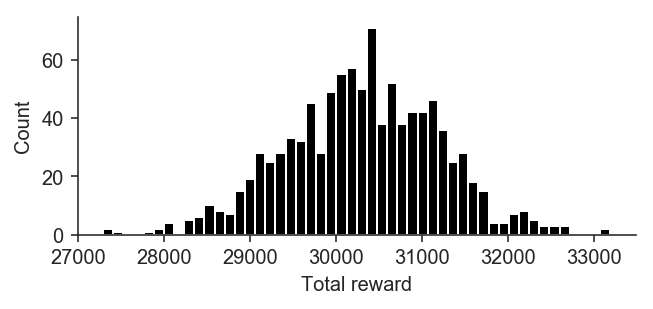

In [12]:
# Init plot
fig = plt.figure(figsize=(5, 2))
grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.8)

plt.subplot(grid[0, 0])
plt.hist(total_Rs, color="black", bins=50)
plt.xlabel("Total reward")
plt.ylabel("Count")
# plt.xlim(0, 10)
_ = sns.despine()